# Testing fixed permutations

This notebook is intended for checking whether the normalizing flow model works good on its own or not. To do so, we will use the training module and turn off the permutation learning part of it.

In [1]:
# Setup so that the path directory is the parent
import sys
sys.path.append('..')
%load_ext autoreload

from lightning.pytorch.loggers import WandbLogger

In [2]:
!nvidia-smi

Tue Jan 17 13:55:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.10   Driver Version: 470.141.10   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:D8:00.0 Off |                    0 |
| N/A   33C    P8    22W / 250W |      0MiB / 22698MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Synthetic scm arguments
scm_generator_class = 'ocd.data.affine_additive.scm.AffineAdditiveSCMGenerator'

dims = 3

# an example of a generation scheme:
graph_generation_scheme = dict(
    graph_generator_type='chain',
    graph_generator_args=dict(
        n=dims,
    )
)

# scm_generator kwargs
scm_generator_kwargs = dict(
    **graph_generation_scheme,
    # function_type="linear_additive",
    function_type="linear_affine_with_exp_modulatd",
    noise_type='gaussian',
    functional_form_generator_args=dict(
        weight_low=0.5,
        weight_high=20,
        noise_std_low=1.0,
        noise_std_high=1.0,
        noise_mean_low=0.0,
        noise_mean_high=0.0
    )
)

In [4]:
observation_size = 1000

interventional_episode_count = 2
interventional_episode_size = 30

# hard intervention setting the value of the intervened node to 2.
intervention_function = 'lambda inputs, params: 2'

In [6]:
%autoreload
from ocd.data.module import OCDDataModule


dm = OCDDataModule(
    seed=100,
    scm_generator_class=scm_generator_class,
    scm_generator_args=scm_generator_kwargs,
    observation_size=observation_size,
    batch_size=32,
    num_workers=0,  # set to 0 for no multiprocessing

    val_size=0.1,
    # val_batch_size=10,
)
dm.setup('fit')

x(2) = gaussian(0.00, 1.00) * exp(sigmoid(8.93)) + sigmoid(3.90)
---------------------

x(0) = gaussian(0.00, 1.00) * exp(sigmoid(x(2) * 0.67 + 2.13)) + sigmoid(x(2) * 19.11 + 7.00)
---------------------

x(1) = gaussian(0.00, 1.00) * exp(sigmoid(x(0) * 12.42 + 5.06)) + sigmoid(x(0) * 10.08 + 1.17)
---------------------



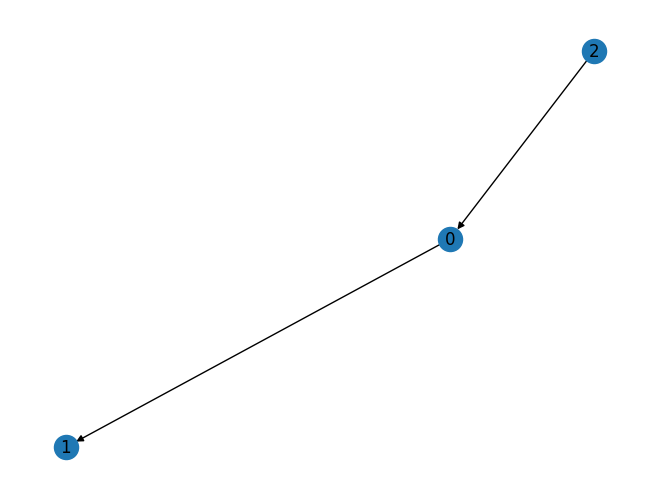

In [7]:
dm.scm.draw()

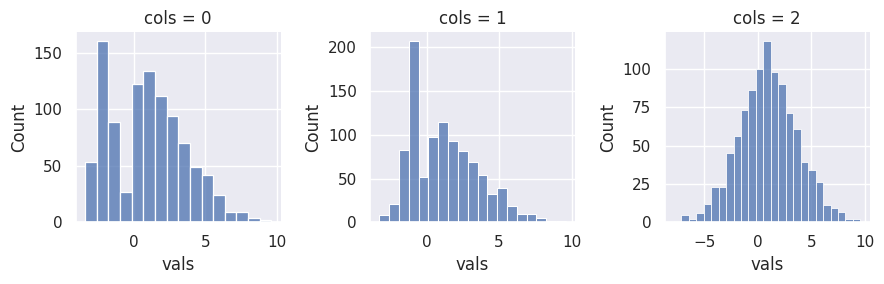

In [8]:
dm.datasets[0].samples

# plot the distribution of all the columns on a shared histogram

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

df = dm.datasets[0].samples
df = df.melt(var_name='cols', value_name='vals')

g = sns.FacetGrid(df, col="cols",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.histplot, "vals")


In [9]:
# Setup callbacks
%autoreload 2

from ocd.training.callbacks import birkhoff_visualizer

my_callbacks = [
    birkhoff_visualizer.BirkhoffCallback(
        dims,
        seed=10101,
        log_every_n_epochs=5,
        log_on_phase_change=False,
        scm=dm.scm,
        write_cost_values=True,
        core_points_has_birkhoff_vertices = True,
        add_permutation_to_name=True,
    )
]

In [10]:
%autoreload 2
from lightning.pytorch import Trainer

wandb_logger = WandbLogger(project="test-project")

trainer = Trainer(
    # For fixed ordering comment out the callback!
    # callbacks=my_callbacks,
    max_epochs=100000,
    accelerator='gpu',
    devices=1,
    num_nodes=0,
    log_every_n_steps=1,
    track_grad_norm="inf",
    logger=wandb_logger,
    # gradient_clip_val=1.0,
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hamidrezakamkari (ordered-causal-discovery). Use `wandb login --relogin` to force relogin


/ssd003/home/hamidk/ocd/venv/lib/python3.9/site-packages/lightning/lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ssd003/home/hamidk/ocd/venv/lib/python3.9/site-pack ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
%autoreload 2
from ocd.training import OrderedTrainingModule


tm = OrderedTrainingModule(
    base_distribution="normflows.distributions.DiagGaussian",
    base_distribution_args=dict(shape=dims, trainable=False),
    in_features=dims,
    layers=[dims * 32] * 3,
    num_transforms=3,
    additive=False,
    elementwise_perm=True,
    
    use_soft_on_maximization=True,
    # (1) Use fixed permutations
    # (1.1) set ordering to a fixed permutation
    # (1.2) set learn_permutation to False
    # (1.3) comment out all the alternating optimization

    # all different orderings of chain 3
    # ordering = [0, 1, 2],
    ordering = [0, 2, 1],
    # ordering = [1, 0, 2],
    # ordering = [1, 2, 0],
    # ordering = [2, 0, 1],
    # ordering = [2, 1, 0],

    # all different ordering of chain 2
    # ordering = [0, 1],
    # ordering = [1, 0],
    
    learn_permutation=False,
    optimizer="torch.optim.AdamW",
    # (2) Use learned permutations
    # (2.1) set learn_permutation to True
    # (2.2) comment out the ordering
    # (2.3) uncomment the alternating optimization

    # learn_permutation=True,
    # log_input_outputs=True,

    # # phase_change_upper_bound=1,

    # maximization_epoch_lower_bound=10,
    # maximization_epoch_upper_bound=200,
    # expectation_epoch_lower_bound=10,
    # expectation_epoch_upper_bound=200,
    
    # starting_phase='maximization',
    
    # criterion_args= dict(
    #         terms=[
    #             dict(
    #                 name="norm(gooz)",
    #                 term_function='lambda training_module, batch: training_module.model.carefl.forward(batch[0]).norm(float("inf"))',
    #                 factor=0,
    #             )
    #         ],
    #         # regularizations=[
    #         #         dict(
    #         #             name="nothing",
    #         #             term_function="lambda batch: torch.zeros(1, device=batch[0].device)",
    #         #             factor="def factor(training_module, results_dict):\n\ttraining_module.loss = results_dict['loss']\n\treturn 0",
    #         #         ),
    #         # ],
    #     ),
    # optimizer=['torch.optim.Adam', 'torch.optim.Adam'],
    # optimizer_args=[{'lr': 1e-3}, {'lr': 1e-3}],
    # optimizer_parameters=[
    #     'model.permutation_model',
    #     'model.carefl', 
    # ],
    # optimizer_is_active=[
    #     'lambda training_module: training_module.get_phase() == "expectation"',
    #     'lambda training_module: training_module.get_phase() == "maximization"',
    # ]
)


In [13]:
trainer.fit(tm, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | OCD  | 58.8 K
-------------------------------
58.8 K    Trainable params
0         Non-trainable params
58.8 K    Total params
0.235     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/ssd003/home/hamidk/ocd/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/home/hamidk/ocd/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/ssd003/home/hamidk/ocd/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
